In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
from keras.utils import np_utils

def load_imgs(save_folder, img_size):
    imgs = []
    files = [file for file in os.listdir(save_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(save_folder, file)
        img = image.load_img(img_path, target_size=img_size)
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
    
    return imgs

In [3]:
nb_categories = 10
nb_exemplars = 14
folder = '../data/images_ca%0.4i_ex%0.4i/' % (nb_categories, nb_exemplars)

In [4]:
X = load_imgs(folder, (200, 200))
df = pd.read_csv(folder + 'data.csv', index_col=0)
shapes = df['shape'].as_matrix()
colors = df['color'].as_matrix()
textures = df['texture'].as_matrix()

In [10]:
from learning2learn.models import simple_cnn

model = simple_cnn(input_shape=(200,200,3), nb_classes=10)

## Check layer output size

In [5]:
X.shape

(150, 200, 200, 3)

In [7]:
model.layers

In [7]:
from learning2learn.util import get_hidden_representations

X_p = get_hidden_representations(model, X, layer_num=6)

In [8]:
X_p.shape

(150, 4096)

In [15]:
int(np.ceil(X.shape[0] / float(32)))

1

## Train model

In [5]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
Y = ohe.fit_transform(shapes.reshape(-1,1))

In [6]:
Y.shape

(150, 10)

In [7]:
X.shape

(150, 200, 200, 3)

In [8]:
test_inds = [i*(nb_exemplars+1) for i in range(nb_categories)]
# The train inds are the set difference of all inds and test inds
train_inds = list(set(range(len(shapes))).difference(test_inds))

In [12]:
model.fit(
    X[train_inds], Y[train_inds], epochs=5,
    shuffle=True, validation_data=(X[test_inds], Y[test_inds]),
    verbose=1, batch_size=32
)

Train on 140 samples, validate on 10 samples
Epoch 1/5
140/140 [==============================] - 4s 32ms/step - loss: 2.8282 - acc: 0.1357 - val_loss: 2.1938 - val_acc: 0.3000
Epoch 2/5
140/140 [==============================] - 5s 34ms/step - loss: 2.1931 - acc: 0.2357 - val_loss: 3.0796 - val_acc: 0.1000
Epoch 3/5
140/140 [==============================] - 5s 34ms/step - loss: 1.8164 - acc: 0.5286 - val_loss: 3.7682 - val_acc: 0.2000
Epoch 4/5
140/140 [==============================] - 5s 38ms/step - loss: 1.4254 - acc: 0.6571 - val_loss: 1.4170 - val_acc: 0.8000
Epoch 5/5
140/140 [==============================] - 5s 37ms/step - loss: 0.3646 - acc: 0.9214 - val_loss: 0.2832 - val_acc: 0.9000


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
loss, acc = model.evaluate(X[test_inds], Y[test_inds], verbose=1)
print(acc)

10/10 [==============================] - 0s 17ms/step
0.899999976158


# Observe images

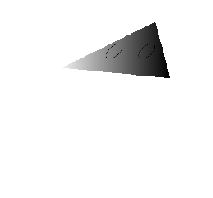

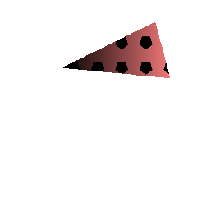

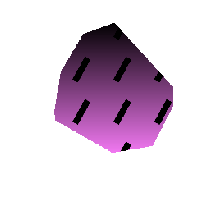

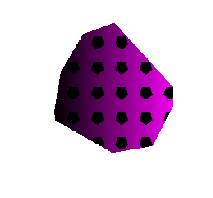

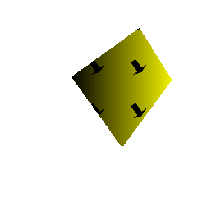

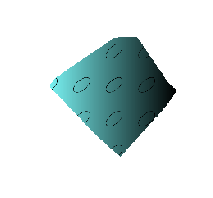

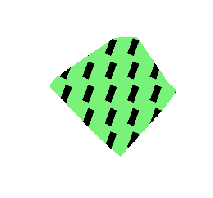

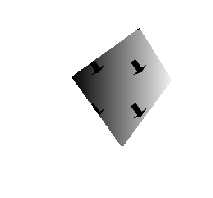

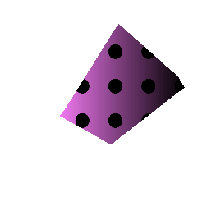

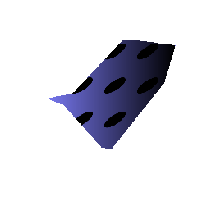

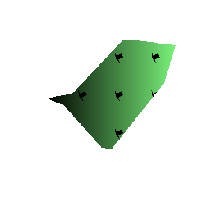

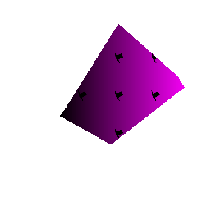

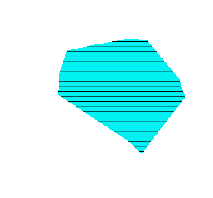

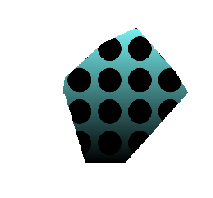

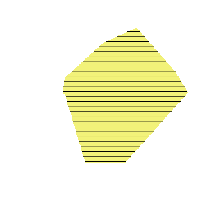

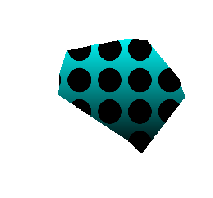

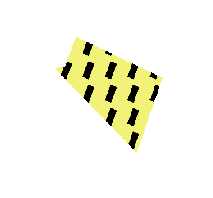

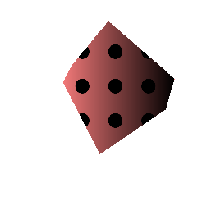

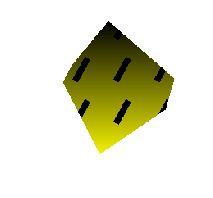

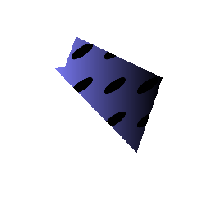

In [10]:
%matplotlib inline
import matplotlib.pylab as plt

for i in range(20):
    plt.figure(figsize=(3, 3))
    plt.imshow(X[i])
    plt.axis('off')
    plt.show()

In [11]:
from learning2learn.models import simple_cnn

input_shape = X.shape[1:]
nb_classes = len(np.unique(shapes))
model = simple_cnn(input_shape, nb_classes)
model.fit(X, Y, epochs=80)

Epoch 1/80
20/20 [==============================] - 8s - loss: 29.2917 - acc: 0.2000
Epoch 2/80
20/20 [==============================] - 4s - loss: 32.9523 - acc: 0.1500
Epoch 3/80
20/20 [==============================] - 4s - loss: 29.5234 - acc: 0.1000
Epoch 4/80
20/20 [==============================] - 4s - loss: 26.1952 - acc: 0.1000
Epoch 5/80
20/20 [==============================] - 4s - loss: 13.2558 - acc: 0.0500
Epoch 6/80
20/20 [==============================] - 4s - loss: 11.9724 - acc: 0.1000
Epoch 7/80
20/20 [==============================] - 4s - loss: 10.9448 - acc: 0.1500
Epoch 8/80
20/20 [==============================] - 4s - loss: 10.1663 - acc: 0.1000
Epoch 9/80
20/20 [==============================] - 4s - loss: 9.5390 - acc: 0.1500
Epoch 10/80
20/20 [==============================] - 4s - loss: 8.9999 - acc: 0.0500
Epoch 11/80
20/20 [==============================] - 5s - loss: 8.5251 - acc: 0.1500
Epoch 12/80
20/20 [==============================] - 5s - loss: 8.

# Check on the second order "test" sets

In [2]:
from learning2learn.util import load_image_dataset

def get_test_set(data_folder):
    contents = [elt for elt in os.listdir(data_folder)
                if elt.startswith('test')]
    contents = sorted(contents)
    X = []
    for dir in contents:
        dir_path = os.path.join(data_folder, dir)
        imgs = load_image_dataset(dir_path, target_size=(200, 200),
                                  feature_info=False)
        X.append(imgs)
    X = np.concatenate(X)

    return X

def load_image_dataset1(data_folder, target_size=(200, 200), interpolation='nearest', feature_info=True):
    # First load the images
    imgs = []
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size, interpolation=interpolation)
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
    if feature_info:
        # Now load the feature info
        feature_file = os.path.join(data_folder, 'data.csv')
        df = pd.read_csv(feature_file, index_col=0)
        shapes = df['shape'].as_matrix()
        # Return both images and shape info
        return imgs, shapes
    else:
        # Return just images
        return imgs

In [26]:
data_folder = os.path.realpath('../data/images_ca0010_ex0014/')
X, shapes = load_image_dataset1(data_folder, target_size=(150, 150), interpolation='bicubic')
#X_test = get_test_set(data_folder)

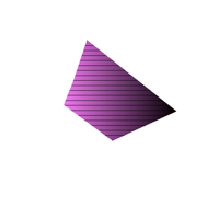

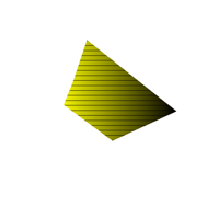

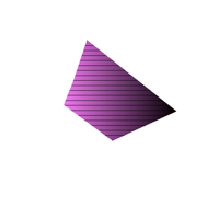

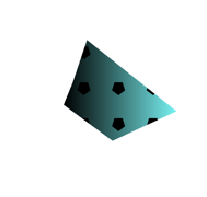

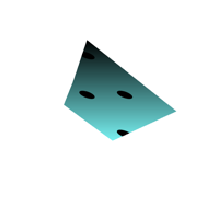

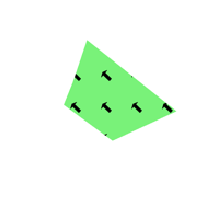

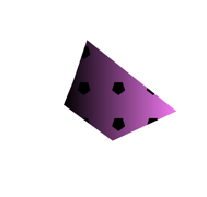

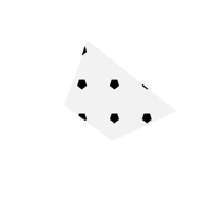

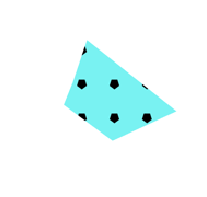

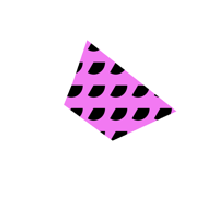

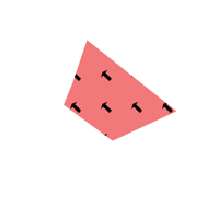

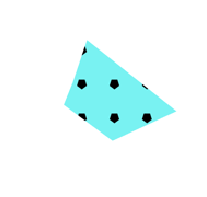

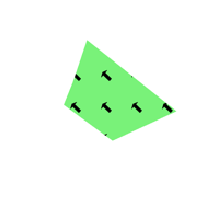

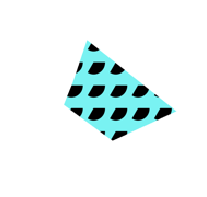

In [27]:
%matplotlib inline
import matplotlib.pylab as plt

for i in range(14):
    plt.figure(figsize=(3,3))
    plt.imshow(X[i])
    plt.axis('off')
    plt.show()

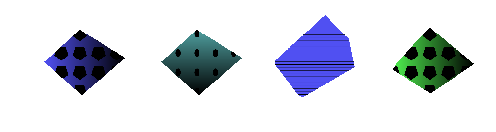

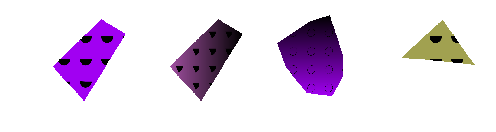

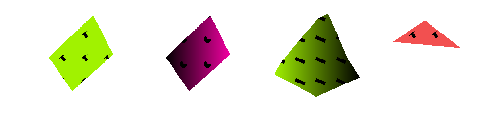

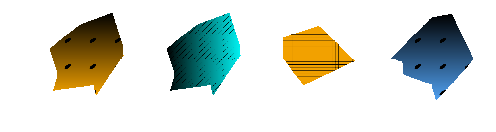

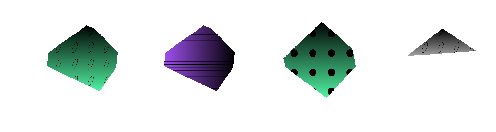

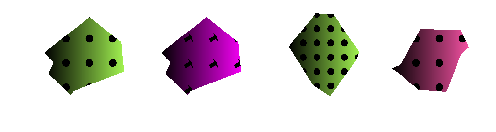

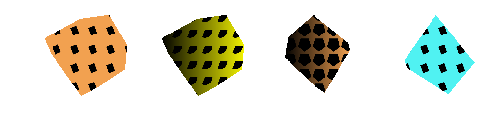

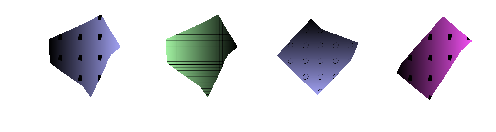

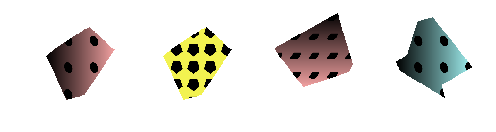

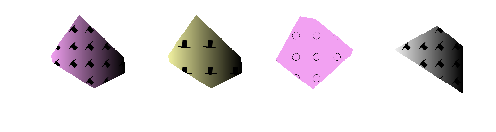

In [6]:
%matplotlib inline
import matplotlib.pylab as plt

for i in range(int(len(X_test)/4)):
    imgs = X_test[4*i:4*(i+1)]
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8,2))
    for j in range(4):
        axes[j].imshow(imgs[j])
        axes[j].axis('off')
    plt.show()
    #plt.imshow(X_test[i])
    #plt.axis('off')
    #plt.show()